# Koopman Operator Example 2

<font color="red"> WIP </font>

### References
- [Lea Bold, et al., On Koopman-based surrogate models for non-holonomic robots, arXiv, 2023](https://arxiv.org/abs/2303.09144)
- [Milan Korda, Igor Mezić, Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control, Automatica, 2018](https://www.sciencedirect.com/science/article/pii/S000510981830133X)
- [薄良彦, クープマン作用素による非線形システムの制御, 計測と制御, 2022](https://www.jstage.jst.go.jp/article/sicejl/61/2/61_133/_article/-char/ja/)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
color = {'orange': '#FF4B00', 'blue': '#005AFF', 'green': '#03AF7A', 'purple': '#990099'}

## Nonlinear System Dynamics
First, a nonlinear affine system is defined as a ground truth model
$$
\begin{align*}
\dot{\bm{x}} &= F(\bm{x}) + G(\bm{x})\bm{u} \\
\end{align*}
$$

Here we use non-holonomic unicycle model as an example,
$$
\begin{align}
&\text{system state }\bm{x}\in \mathbb{R}^3 \text{:} \quad \bm{x} = [p_x, p_y, \theta], \nonumber \\
&\text{control input }\bm{u}\in \mathbb{R}^2 \text{:} \quad \bm{u} = [v, \omega], \nonumber \\
\end{align}
$$

The state update rule is given by the following equation.
$$
\begin{equation}
\left\{
\begin{align}
\frac{\rm{d}}{\rm{d}t} p_x &= v \cos\theta  \nonumber \\
\frac{\rm{d}}{\rm{d}t} p_y &= v \sin\theta  \nonumber \\
\frac{\rm{d}}{\rm{d}t} \theta &=  \omega  \nonumber \\
\end{align}
\right. \nonumber
\end{equation}
$$

In [27]:
# define a nonlinear affine system (ground truth)
# this system is called as "unicycle model" in the robotics field
class NonlinearSystem:
    def __init__(self, x_init: np.ndarray):
        # initialize the state
        self.x = x_init # x is 3 dimensional: [x1, x2, x3]

    def step(self, u: np.ndarray, dt: float):
        # load control input and current state
        u1, u2 = u # u is 2 dimensional
        x1, x2, x3 = self.x # x is 3 dimensional

        # update state
        x_dot = np.array([
            np.cos(x3) * u1,
            np.sin(x3) * u1,
            u2,
        ])
        self.x = self.x + x_dot * dt

    def get_state(self):
        return self.x.copy()

## Generate Training Data

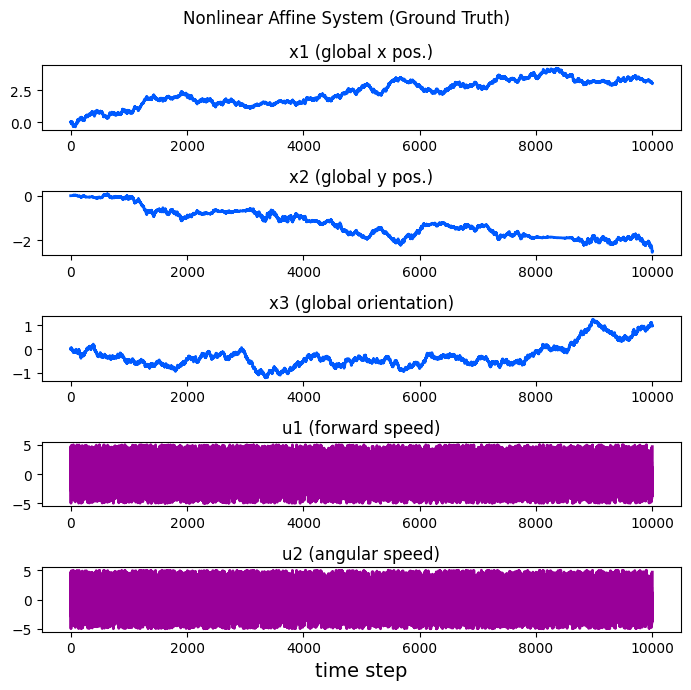

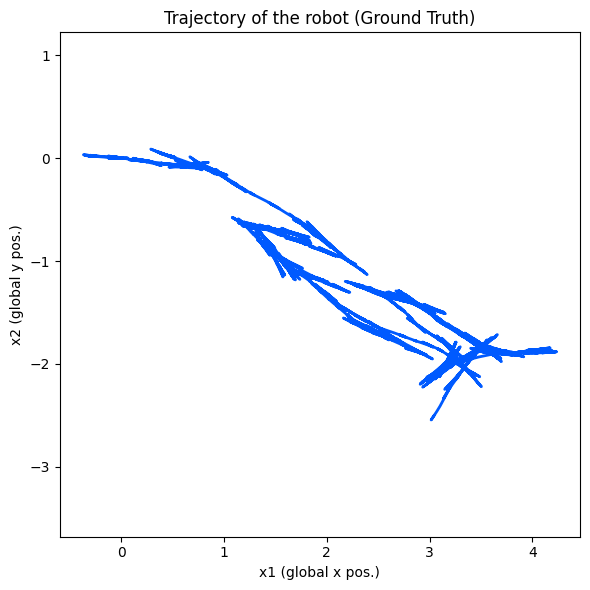

In [28]:
# try simulation with the ground truth system
dt = 0.01 # time step [s]
T = 100.0 # simulation time [s]
n_steps = int(T / dt)
x_init = np.array([0.0, 0.0, 0.0])
system = NonlinearSystem(x_init)
u1_min, u1_max = -5.00, +5.00 # set velocity limits
u2_min, u2_max = -3.14, +3.14 # set angular velocity limits

# simulate the system
x_history = x_init # x log
u_history = np.array([]) # u log
for t in range(n_steps):
    # generate u as a random number between umin and umax
    u = np.array([
        np.random.uniform(u1_min, u1_max),
        np.random.uniform(u2_min, u2_max)
    ])
    # update the system state
    system.step(u, dt)
    # stack system state vertically to x_history
    x_history = np.vstack((x_history, system.get_state()))
    if t == 0:
        u_history = u
    else:
        u_history = np.vstack((u_history, u))

# plot the results, top figure is x1, middle figure is x2, bottom figure is u
ax, fig = plt.subplots(5, 1, figsize=(7, 7))
# add suptitle to the figure
plt.suptitle('Nonlinear Affine System (Ground Truth)')
fig[0].set_title('x1 (global x pos.)')
fig[0].plot(x_history[:, 0], lw=2, label='x1 (global x pos.)', color=color['blue'])
fig[1].set_title('x2 (global y pos.)')
fig[1].plot(x_history[:, 1], lw=2, label='x2', color=color['blue'])
fig[2].set_title('x3 (global orientation)')
fig[2].plot(x_history[:, 2], lw=2, label='x3', color=color['blue'])
fig[3].set_title('u1 (forward speed)')
fig[3].plot(u_history, lw=2, label='u', color=color['purple'])
fig[4].set_title('u2 (angular speed)')
fig[4].plot(u_history, lw=2, label='u', color=color['purple'])
fig[4].set_xlabel('time step', fontsize=14)
plt.tight_layout()
plt.savefig('ex2_training.png', dpi=300)
plt.show()

# plot trajectory 
plt.figure(figsize=(6, 6))
plt.plot(x_history[:, 0], x_history[:, 1], lw=2, label='trajectory', color=color['blue'])
plt.xlabel('x1 (global x pos.)')
plt.ylabel('x2 (global y pos.)')
plt.title('Trajectory of the robot (Ground Truth)')
plt.axis('equal')
plt.tight_layout()
plt.savefig('ex2_training_trajectory.png', dpi=300)
plt.show()


## Define Koopman Eigenfunctions Manually

Here we define the koopman eigenfunctions manually. The number of eigenfunctions is $N$.
$$
\begin{align*}
    \{\psi_i : i = 1, \ldots, N\} &= 
    \{ x_1, x_2, \sin(x_2), \cos(x_2)\}
\end{align*}
$$

Then, original state $\bm{x}$ can be transformed to the feature space $\bm{z}$ by the eigenfunctions,
$$
\begin{align*}
    \bm{z} &= [\psi_1(\bm{x}), \ldots, \psi_N(\bm{x})]^T, \\
              &= \bm{\psi}(\bm{x}).
\end{align*}
$$

In [29]:
def psi_xx(x: np.ndarray):
    # define koopman eigenfunctions for state x
    return np.array([
        x[0],
        x[1],
        x[2],
    ]).T

def psi_xu(x: np.ndarray):
    # define koopman eigenfunctions for input u
    return np.array([
        [np.cos(x[2]), 0],
        [np.sin(x[2]), 0],
        [0, 1],
    ])

## Fit Linear Transformation Matrices: A, B, C

Use x_history and u_history generated above as training data.

In [30]:
# Prepare Training Data
# X = [x1, x2, ..., xk]
X = x_history.T
print("X shape:", X.shape)
# X_lift = [psi_xx(x1), psi_xx(x2), ..., psi_xx(xk)]
X_lift = psi_xx(X).T
print("X_lift shape:", X_lift.shape)
# Y = [x2, x3, ..., xk, xk]
Y = np.append(X[:, 1:], X[:, -1:], axis=1)
print("Y shape:", Y.shape)
# Y_lift = [psi_xx(x2), psi_xx(x3), ..., psi_xx(xk), psi_xx(xk)]
Y_lift = psi_xx(Y).T
print("Y_lift shape:", Y_lift.shape)
# U = [u1, u2, ..., uk]
U = u_history.T
u_last = U[:, -1].reshape(U.shape[0], 1)
U = np.append(U, u_last, axis=1) # set the last input as the same as the previous one
print("U shape:", U.shape)
# U_lift = [psi_xu(x1)*u1, psi_xu(x2)*u2, ..., psi_xu(xk)*uk]
U_lift = np.array([])
for i in range(U.shape[1]):
    x = X[:, i]
    u = U[:, i]
    u_lift = psi_xu(x) @ u
    if i == 0:
        U_lift = np.array(u_lift).reshape(-1, 1)
    else:
        U_lift = np.append(U_lift, u_lift.reshape(-1, 1), axis=1)
print("U_lift shape:", U_lift.shape)

# check the size of the matrices
size_k = X.shape[1]
size_N = X_lift.shape[0]
size_m = U_lift.shape[0]
print("size_k:", size_k)
print("size_N:", size_N)
print("size_m:", size_m)

# fit A, B
X_lift_U_lift = np.vstack((X_lift, U_lift))
AB = Y_lift @ np.linalg.pinv(X_lift_U_lift)
A = AB[:, :size_N]
print("Fit A Matrix, A shape is", A.shape)
B = AB[:, size_N:]
print("Fit B Matrix, B shape is", B.shape)

# fit C
C = X @ np.linalg.pinv(X_lift)
print("Fit C Matrix, C shape is", C.shape)

X shape: (3, 10001)
X_lift shape: (3, 10001)
Y shape: (3, 10001)
Y_lift shape: (3, 10001)
U shape: (2, 10001)
U_lift shape: (3, 10001)
size_k: 10001
size_N: 3
size_m: 3
Fit A Matrix, A shape is (3, 3)
Fit B Matrix, B shape is (3, 3)
Fit C Matrix, C shape is (3, 3)


In [31]:
print("A is \n", A)
print("B is \n", B)
print("C is \n", C)

# [FOR DEBUG] ideal matrices in this problem
# A = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1],
# ])
# B = np.array([
#     [dt, 0, 0],
#     [0, dt, 0],
#     [0, 0, dt],
# ])
# C = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1],
# ])

A is 
 [[ 1.00001873e+00  3.76475396e-05 -7.42234711e-06]
 [ 2.76418842e-05  1.00005556e+00 -1.09541951e-05]
 [-8.06383162e-06 -1.62087535e-05  1.00000320e+00]]
B is 
 [[ 9.99639765e-03 -7.78374491e-06  9.28450344e-07]
 [-5.31649416e-06  9.98851244e-03  1.37024395e-06]
 [ 1.55095483e-06  3.35120977e-06  9.99960027e-03]]
C is 
 [[ 1.00000000e+00  6.01852916e-15 -5.10292511e-15]
 [ 1.08857094e-15  1.00000000e+00 -4.84914594e-15]
 [-1.01314537e-16  1.53371478e-15  1.00000000e+00]]


## Approximated System Dynamics

$$
\begin{align*}
    \bm{z}[k+1] &= A\bm{z}[k] + B\bm{u}[k] \\
    \hat{\bm{x}}[k] &= C\bm{z}[k]
\end{align*}
$$

In [32]:
# define a nonlinear affine system (ground truth)
class ApproximatedSystem:
    def __init__(self, x_init: np.ndarray, A: np.ndarray, B: np.ndarray, C: np.ndarray, psi_xx: callable, psi_xu: callable) -> None:
        # initialize the state
        self.x = x_init # x is 3 dimensional: [x1, x2, x3]

        # define the system parameters
        self.A = A
        self.B = B
        self.C = C
        self.psi_xx = psi_xx
        self.psi_xu = psi_xu

        # get initial state in the lifted space
        self.z = self.psi_xx(self.x) # z is the latent state in the lifted linear space

    def step(self, u: np.ndarray) -> None:
        # update state
        self.z = self.A @ self.z + self.B @ (self.psi_xu(self.x) @ u)
        self.x = self.C @ self.z

    def get_state(self) -> np.ndarray:
        return self.x.copy()

## Compare the Approximated System with the Original System

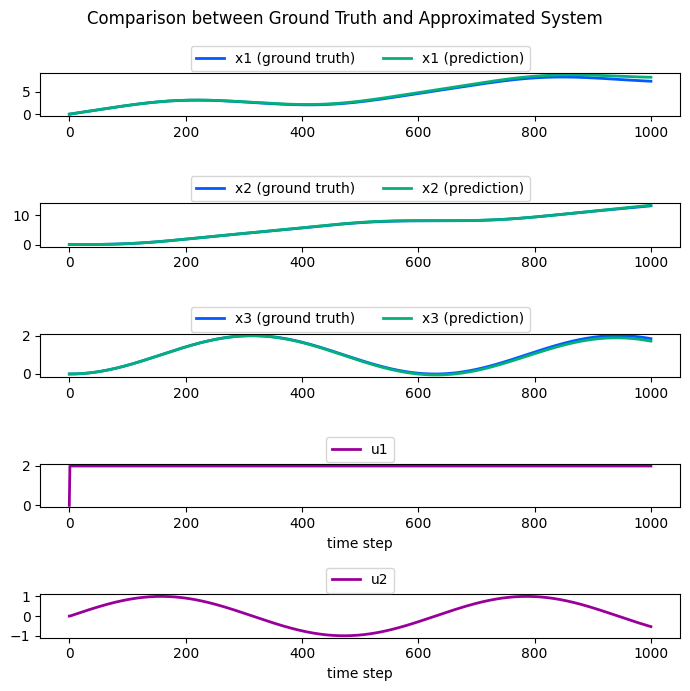

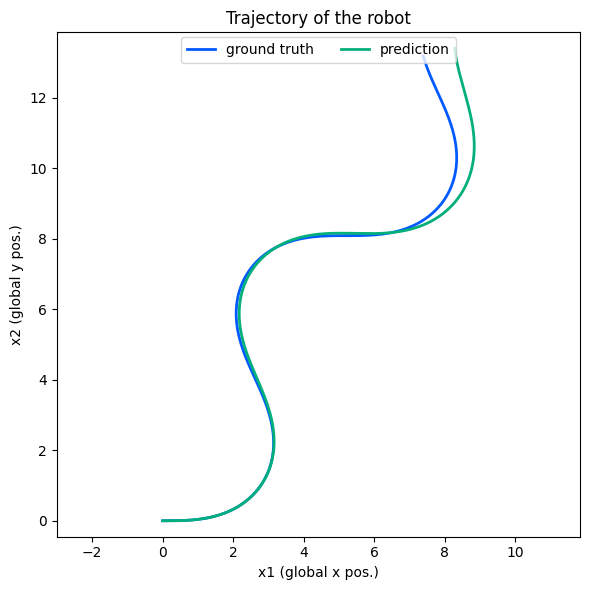

In [33]:
# try simulation with both ground truth and learned system
dt = 0.01 # time step [s] # [FOR TEST]
T = 10.0 # simulation time [s]
n_steps = int(T / dt)
x_init = np.array([0.0, 0.0, 0.0])
ground_truth_system = NonlinearSystem(x_init)
approximated_system = ApproximatedSystem(x_init, A, B, C, psi_xx, psi_xu)
u1_min, u1_max = -1.00, +1.00 # set velocity limits
u2_min, u2_max = -1.57, +1.57 # set angular velocity limits

# simulate the system
x_gt_history = x_init # x log of ground truth system
x_ap_history = x_init # x log of approximated system
u_history = np.array([0.0, 0.0]) # u log
for t in range(n_steps):
    # [pattern 1] generate u as a random number
    # u = np.array([
    #     np.random.uniform(u1_min, u1_max),
    #     np.random.uniform(u2_min, u2_max)
    # ])
    # [pattern 2] generate u as a sinusoidal function
    u = np.array([
        2.0, 
        np.sin(t * dt)
    ])

    # update state of both systems
    ground_truth_system.step(u, dt)
    approximated_system.step(u)

    # save system state and control input
    x_gt_history = np.vstack((x_gt_history, ground_truth_system.get_state()))
    x_ap_history = np.vstack((x_ap_history, approximated_system.get_state()))
    u_history = np.vstack((u_history, u))

# plot the results, top figure is x1, middle figure is x2, bottom figure is u
ax, fig = plt.subplots(5, 1, figsize=(7, 7))
# add suptitle to the figure
plt.suptitle('Comparison between Ground Truth and Approximated System')
# x1
fig[0].plot(x_gt_history[:, 0], lw=2, label='x1 (ground truth)', color=color['blue'])
fig[0].plot(x_ap_history[:, 0], lw=2, label='x1 (prediction)', color=color['green'])
fig[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# x2
fig[1].plot(x_gt_history[:, 1], lw=2, label='x2 (ground truth)', color=color['blue'])
fig[1].plot(x_ap_history[:, 1], lw=2, label='x2 (prediction)', color=color['green'])
fig[1].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# x3
fig[2].plot(x_gt_history[:, 2], lw=2, label='x3 (ground truth)', color=color['blue'])
fig[2].plot(x_ap_history[:, 2], lw=2, label='x3 (prediction)', color=color['green'])
fig[2].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# u1
fig[3].plot(u_history[:, 0], lw=2, label='u1', color=color['purple'])
fig[3].set_xlabel('time step')
fig[3].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# u2
fig[4].plot(u_history[:, 1], lw=2, label='u2', color=color['purple'])
fig[4].set_xlabel('time step')
fig[4].legend(loc="lower center", bbox_to_anchor=(0.5, 1.04,), borderaxespad=0, ncol=2)
# adjust layout and show figure
plt.tight_layout()
plt.savefig('ex2_evaluation.png', dpi=300)
plt.show()

# plot trajectory 
plt.figure(figsize=(6, 6))
plt.plot(x_gt_history[:, 0], x_gt_history[:, 1], lw=2, label='ground truth', color=color['blue'])
plt.plot(x_ap_history[:, 0], x_ap_history[:, 1], lw=2, label='prediction', color=color['green'])
plt.xlabel('x1 (global x pos.)')
plt.ylabel('x2 (global y pos.)')
plt.title('Trajectory of the robot')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 0.94,), borderaxespad=0, ncol=2)
plt.axis('equal')
plt.tight_layout()
plt.savefig('ex2_evaluation_trajectory.png', dpi=300)
plt.show()